In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

In [2]:
# 设置文件夹路径
folder_path = "./data"

# 使用glob获取所有csv文件路径
csv_files = glob.glob(folder_path + "/Fpec_1-Bias_0.csv")

In [3]:
df = pd.read_csv(csv_files[0], header=None, names=['timestamp', 'state', 'head_x', 'head_y', 'tail_x', 'tail_y'])
df = df[((df['head_x'].diff().abs()>=1) |
        (df['head_y'].diff().abs()>=1)) & 
        ((df['tail_x'].diff().abs()>=1) |
        (df['tail_y'].diff().abs()>=1))
        ]

df['head_x'] = df['head_x'] / 515 * 2
df['head_y'] = -df['head_y'] / 515 * 2
df['tail_x'] = df['tail_x'] / 515 * 2
df['tail_y'] = -df['tail_y'] / 515 * 2

df = df.reset_index(drop=True)
df.head(-5)

,timestamp,state,head_x,head_y,tail_x,tail_y
0,0.0,0.0,2.780583,-1.976699,2.776699,-2.135922
1,0.0,0.0,2.784466,-1.976699,2.780583,-2.135922
2,0.0,0.0,2.780583,-1.976699,2.780583,-2.132039
3,0.0,0.0,2.784466,-1.972816,2.780583,-2.135922
4,0.0,0.0,2.788350,-1.976699,2.784466,-2.132039
...,...,...,...,...,...,...
7511,0.0,0.0,1.378641,-2.609709,1.238835,-2.520388
7512,0.0,0.0,1.390291,-2.609709,1.242718,-2.524272
7513,0.0,0.0,1.398058,-2.609709,1.246602,-2.528155
7514,0.0,0.0,1.405825,-2.609709,1.250485,-2.528155


In [4]:
# 2. 定义计算函数（包括速度、角速度、加速度）
def compute_velocity_and_yaw_from_df(row, df):
    head_x, head_y = row['head_x'], row['head_y']
    tail_x, tail_y = row['tail_x'], row['tail_y']
    
    # 获取当前和上一时刻的 timestamp
    timestamp = row['timestamp']
    prev_timestamp = df.iloc[row.name - 1]['timestamp'] if row.name > 0 else timestamp
    
    # 计算时间差（时间步长）
    dt = timestamp - prev_timestamp

    x = (row['head_x'] + row['tail_x'])/2
    y = (row['head_y'] + row['tail_y'])/2
    
    prev_head_x = row['head_x'] if row.name == 0 else df.iloc[row.name - 1]['head_x']
    prev_head_y = row['head_y'] if row.name == 0 else df.iloc[row.name - 1]['head_y']
    prev_tail_x = row['tail_x'] if row.name == 0 else df.iloc[row.name - 1]['tail_x']
    prev_tail_y = row['tail_y'] if row.name == 0 else df.iloc[row.name - 1]['tail_y']
    prev_x = (prev_head_x+prev_tail_x)/2
    prev_y = (prev_head_y+prev_tail_y)/2

    # 计算当前时刻与前一时刻的位移向量（头部和尾部分别）
    dx = head_x - tail_x
    dy = head_y - tail_y

    yaw = np.arctan2(dy, dx) 

    x_velocity = (x - prev_x)/dt if dt != 0 else 0
    y_velocity = (y - prev_y)/dt if dt != 0 else 0
    forward_velocity = x_velocity * np.cos(yaw) + y_velocity * np.sin(yaw)
    lateral_velocity = -x_velocity * np.sin(yaw) + y_velocity * np.cos(yaw)

    prev_yaw = yaw if row.name == 0 else np.arctan2(df.iloc[row.name - 1]['head_y'] - df.iloc[row.name - 1]['tail_y'],
                                                       df.iloc[row.name - 1]['head_x'] - df.iloc[row.name - 1]['tail_x'])
    angular_velocity = (yaw - prev_yaw) / dt if dt != 0 else 0

    # 计算角加速度（角速度的变化率）
    prev_angular_velocity = angular_velocity if row.name == 0 else (np.arctan2(df.iloc[row.name - 1]['head_y'] - df.iloc[row.name - 1]['tail_y'],
                                                                           df.iloc[row.name - 1]['head_x'] - df.iloc[row.name - 1]['tail_x']) - prev_yaw) / dt
    angular_acceleration = (angular_velocity - prev_angular_velocity) / dt if dt != 0 else 0.0

    # 计算前进速度加速度（前进速度的变化率）
    if row.name > 1:
        prev_dt = df.iloc[row.name - 1]['timestamp'] - df.iloc[row.name - 2]['timestamp']
        preprev_head_x =  df.iloc[row.name - 2]['head_x']
        preprev_head_y =  df.iloc[row.name - 2]['head_y']
        preprev_tail_x = df.iloc[row.name - 2]['tail_x']
        preprev_tail_y = df.iloc[row.name - 2]['tail_y']
        preprev_x = (preprev_head_x+preprev_tail_x)/2
        preprev_y = (preprev_head_y+preprev_tail_y)/2
        prex_velocity = (prev_x - preprev_x)/prev_dt if prev_dt != 0 else 0
        prey_velocity = (prev_y - preprev_y)/prev_dt if prev_dt != 0 else 0
        preprev_yaw = np.arctan2(preprev_head_y- preprev_tail_y, preprev_head_x-preprev_tail_x) 
        prev_forward_velocity = prex_velocity * np.cos(prev_yaw) + prey_velocity * np.sin(prev_yaw)
        prev_lateral_velocity = -prex_velocity * np.sin(prev_yaw) + prey_velocity * np.cos(prev_yaw)
        prev_angular_velocity =  (prev_yaw - preprev_yaw)/prev_dt if prev_dt != 0 else 0
    else:
        prev_forward_velocity = forward_velocity
        prev_lateral_velocity = lateral_velocity
        prev_angular_velocity = angular_velocity
   
    forward_acceleration = (forward_velocity - prev_forward_velocity) / dt if dt != 0 else 0.0
    lateral_acceleration = (lateral_velocity - prev_lateral_velocity) / dt if dt != 0 else 0.0
    angular_acceleration = (angular_velocity - prev_angular_velocity) / dt if dt != 0 else 0.0

    return yaw, forward_velocity, lateral_velocity, angular_velocity, angular_acceleration, forward_acceleration, lateral_acceleration


In [5]:
# 计算每一行的数据
df['yaw'], df['forward_velocity'], df['lateral_velocity'], df['angular_velocity'], df['angular_acceleration'], df['forward_acceleration'], df['lateral_acceleration'] = zip(*df.apply(compute_velocity_and_yaw_from_df, axis=1, df=df))

# 输出结果
print(df)
velocity_threshold = 0.01
# 过滤掉速度小于阈值的轨迹点
df_filtered = df[df['forward_velocity'] > velocity_threshold].reset_index(drop=True)



C:\Users\HP\AppData\Local\Temp\ipykernel_15052\3172854244.py:39: RuntimeWarning: invalid value encountered in scalar divide
  prev_angular_velocity = angular_velocity if row.name == 0 else (np.arctan2(df.iloc[row.name - 1]['head_y'] - df.iloc[row.name - 1]['tail_y'],


      timestamp  state    head_x    head_y    tail_x    tail_y       yaw  \
0           0.0    0.0  2.780583 -1.976699  2.776699 -2.135922  1.546411   
1           0.0    0.0  2.784466 -1.976699  2.780583 -2.135922  1.546411   
2           0.0    0.0  2.780583 -1.976699  2.780583 -2.132039  1.570796   
3           0.0    0.0  2.784466 -1.972816  2.780583 -2.135922  1.546991   
4           0.0    0.0  2.788350 -1.976699  2.784466 -2.132039  1.545802   
...         ...    ...       ...       ...       ...       ...       ...   
7516        0.0    0.0  1.417476 -2.613592  1.266019 -2.539806 -0.453339   
7517        0.0    0.0  1.425243 -2.609709  1.269903 -2.543689 -0.401871   
7518        0.0    0.0  1.429126 -2.609709  1.273786 -2.539806 -0.422854   
7519        0.0    0.0  1.436893 -2.605825  1.285437 -2.532039 -0.453339   
7520        0.0    0.0  1.444660 -2.605825  1.289320 -2.528155 -0.463648   

      forward_velocity  lateral_velocity  angular_velocity  \
0                  0.0   

In [6]:
import re

# 假设 df_filtered 是你的 DataFrame

# 定义一个函数来处理字符串并提取有效的浮点数
def convert_state_to_array(state_str):
    # 处理类似 'np.float64(0.8686709298331904)' 的情况，提取数值部分
    state_str = re.sub(r'np\.float64\((.*?)\)', r'\1', state_str)
    
    # 去掉两边的方括号
    state_str = state_str.strip('[]')
    
    # 按逗号分割字符串，得到一个列表的字符串
    state_list = state_str.split(', ')
    
    # 将列表中的字符串转换为浮点数
    state_float = [float(x) for x in state_list]
    
    # 返回浮点数列表
    return np.array(state_float)

# 使用 apply 方法将该函数应用到 'state' 列
df_filtered['state'] = df_filtered['state'].apply(convert_state_to_array)

# 打印转换后的 DataFrame 以检查
print(df_filtered.head())

Empty DataFrame
Columns: [timestamp, state, head_x, head_y, tail_x, tail_y, yaw, forward_velocity, lateral_velocity, angular_velocity, angular_acceleration, forward_acceleration, lateral_acceleration]
Index: []


In [7]:
df_filtered[df_filtered['forward_acceleration']<0]

,timestamp,state,head_x,head_y,tail_x,tail_y,yaw,forward_velocity,lateral_velocity,angular_velocity,angular_acceleration,forward_acceleration,lateral_acceleration


In [8]:
# 假设 df_filtered 是你的 DataFrame，并且已经有了 'state'、'forward_velocity' 和 'lateral_velocity' 列

# 设置速度变化的阈值
delta_v_threshold = 0.02  # 可以根据需求调整，这里假设 5 m/s 的变化超过了阈值

# 计算速度差值
df_filtered['delta_forward_velocity'] = df_filtered['forward_velocity'].diff().abs()
df_filtered['delta_lateral_velocity'] = df_filtered['lateral_velocity'].diff().abs()

# 过滤掉速度差值超过阈值的点
df_filtered_filtered = df_filtered[(df_filtered['delta_forward_velocity'] < delta_v_threshold) & 
                                     (df_filtered['forward_acceleration'].abs() < 1)&
                                     (df_filtered['angular_velocity'].diff().abs() <1)&
                                    #   (df_filtered['angular_velocity'].abs() <3)&
                                    (df_filtered['delta_lateral_velocity'] < delta_v_threshold) ].reset_index(drop=True)

def moving_average(df, column_name, window_size=5):
    return df[column_name].rolling(window=window_size, min_periods=1).mean()

# 对加速度和速度列进行平滑处理
df_filtered_filtered['smoothed_forward_velocity'] = moving_average(df_filtered_filtered, 'forward_velocity', window_size=10)
df_filtered_filtered['smoothed_forward_acceleration'] = moving_average(df_filtered_filtered, 'forward_acceleration', window_size=10)

# 画出控制状态中每个变量和速度的关系（关于时间）
plt.figure(figsize=(14, 10))

# 假设 state 中有多个变量，使用循环依次绘制每个状态变量和速度随时间的关系
num_state_variables = df_filtered_filtered['state'].iloc[0].shape[0]  # 获取状态向量的维度

# 绘制每个状态变量与时间的关系
for i in range(num_state_variables):
    # 画状态变量 vs 时间
    plt.subplot(num_state_variables, 2, 2*i + 1)
    plt.plot(df_filtered_filtered['timestamp'], df_filtered_filtered['state'].apply(lambda x: x[i]), marker='o', linestyle='-', color='b')
    plt.title(f'State variable {i+1} vs Time')
    plt.xlabel('Time (s)')
    plt.ylabel(f'State variable {i+1}')
    
    # 画前进速度 vs 时间
    plt.subplot(num_state_variables, 2, 2*i + 2)
    plt.plot(df_filtered_filtered['timestamp'], df_filtered_filtered['smoothed_forward_acceleration'], linestyle='-', color='r')
    plt.title(f'forward_acceleration vs Time')
    plt.xlabel('Time (s)')
    plt.ylabel('forward_acceleration')

# 自动调整布局，防止重叠
plt.tight_layout()
plt.show()

IndexError: single positional indexer is out-of-bounds

<Figure size 1400x1000 with 0 Axes>

In [ ]:
def loss_function(predictions, actuals):
    return 10 * np.mean((predictions - actuals) ** 2)

In [99]:
def sgd_optimizer(df, learning_rate=0.01, epochs=100):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # 初始化模型参数
    params = np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0])
    # 假设三个模型参数: [S_u, C_d, C_l, A_pl1, A_pl2, A_pr1, A_pr2]
    
    for epoch in range(epochs):
        total_train_loss = 0
        # 随机打乱数据
        train_df_shuffled = train_df.sample(frac=1).reset_index(drop=True)
        
        for idx, row in train_df_shuffled.iterrows():
            # 获取预测值
            u_dot = row['forward_acceleration']
            # print(u_dot)
            u = row['forward_velocity'] 
            v = row['lateral_velocity'] 
            w = row['angular_velocity']
            f_l = row['state'][0]
            f_r = row['state'][1]
            
            
            u_dot_pred =  - 0.5*1000*params[0]*params[1]*u*np.sqrt(u**2+v**2)/17.446 + 0.5/17.446*1000*params[0]*params[2]*v*np.sqrt(u**2+v**2)*math.atan(v/u) \
                    + (params[3]*f_l**2 + params[4]*f_l + params[3]*f_r**2 + params[4]*f_r)/17.446
            # print(u_dot)
            # 计算损失
            loss = loss_function(np.array([u_dot_pred]), np.array([u_dot]) )#+ params[3]**2 + params[4]**2 + params[5]**2 + params[6]**2)
            total_train_loss += loss
            
            # 计算梯度
            grad_S_u = 20 * (u_dot_pred - u_dot) * (- 0.5*1000*params[1]*u*np.sqrt(u**2+v**2)/17.446 + 0.5/17.446*1000*params[2]*v*np.sqrt(u**2+v**2)*math.atan(v/u))
            grad_C_d = 20 * (u_dot_pred - u_dot) * (- 0.5*1000*params[0]*u*np.sqrt(u**2+v**2)/17.446)
            grad_C_l = 20 * (u_dot_pred - u_dot) * (0.5/17.446*1000*params[0]*v*np.sqrt(u**2+v**2)*math.atan(v/u)) 
            grad_A_pl1 = 20 * (u_dot_pred - u_dot) * f_l**2 /17.446 #+ 2 * params[3]
            grad_A_pl2 = 20 * (u_dot_pred - u_dot) * f_l /17.446 #+ 2 * params[4] 
            # grad_A_pr1 = 2 * (u_dot_pred - u_dot) * f_r**2 /17.446 #+ 2 * params[5]
            # grad_A_pr2 = 2 * (u_dot_pred - u_dot) * f_r /17.446 #+ 2 * params[6]
            
            # 更新参数
            params[0] -= learning_rate * grad_S_u
            # params[0] = max(params[0], 0)
            params[1] -= learning_rate * grad_C_d
            # params[1] = max(params[1], 0)
            params[2] -= learning_rate * grad_C_l
            # params[2] = max(params[2], 0)
            params[3] -= learning_rate * grad_A_pl1
            params[4] -= learning_rate * grad_A_pl2
            # params[5] -= learning_rate * grad_A_pr1
            # params[6] -= learning_rate * grad_A_pr2
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_train_loss/len(train_df_shuffled)}")
        # print(f_l )
        # print(params[3]*f_l**2 + params[4]*f_l )
        # 在测试集上计算损失
        total_test_loss = 0
        for idx, row in test_df.iterrows():
            u_dot = row['forward_acceleration']
            u = row['forward_velocity']
            v = row['lateral_velocity']
            f_l = row['state'][0]
            f_r = row['state'][1]
            
            u_dot_pred = - 0.5 * 1000 * params[0] * params[1] * u * np.sqrt(u**2 + v**2) / 17.446 \
                        + 0.5 / 17.446 * 1000 * params[0] * params[2] * v * np.sqrt(u**2 + v**2) * math.atan(v / u) \
                        + (params[3] * f_l**2 + params[4] * f_l + params[3] * f_r**2 + params[4] * f_r) / 17.446
            
            loss = loss_function(np.array([u_dot_pred]), np.array([u_dot]))
            total_test_loss += loss

        # 打印训练损失和测试损失
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss/len(train_df_shuffled)}, Test Loss: {total_test_loss/len(test_df)}")
        print(u_dot, u_dot_pred)
        print(params)
    return params


In [132]:
params = sgd_optimizer(df_filtered_filtered, learning_rate=0.0001, epochs=1000)

Epoch 1/1000, Loss: 1.230671957363375
Epoch 1/1000, Train Loss: 1.230671957363375, Test Loss: 0.7300553684255466
0.018182671028044304 0.4256456931407188
[0.74229614 0.75711286 0.98884416 1.00836017 1.00747201 1.
 1.        ]
Epoch 2/1000, Loss: 0.7228499382107586
Epoch 2/1000, Train Loss: 0.7228499382107586, Test Loss: 0.5251244170882577
0.018182671028044304 0.38313691414106626
[0.62409962 0.6624341  0.9750437  1.00921516 1.00865354 1.
 1.        ]
Epoch 3/1000, Loss: 0.603909240714801
Epoch 3/1000, Train Loss: 0.603909240714801, Test Loss: 0.4613098737427969
0.018182671028044304 0.35500360842037937
[0.55070115 0.61445748 0.96215245 1.00703372 1.00724009 1.
 1.        ]
Epoch 4/1000, Loss: 0.5583739736564963
Epoch 4/1000, Train Loss: 0.5583739736564963, Test Loss: 0.4350510974467052
0.018182671028044304 0.33431486145959555
[0.49911202 0.58819002 0.95034833 1.0032485  1.00442008 1.
 1.        ]
Epoch 5/1000, Loss: 0.5358345770096097
Epoch 5/1000, Train Loss: 0.5358345770096097, Test Los

KeyboardInterrupt: 

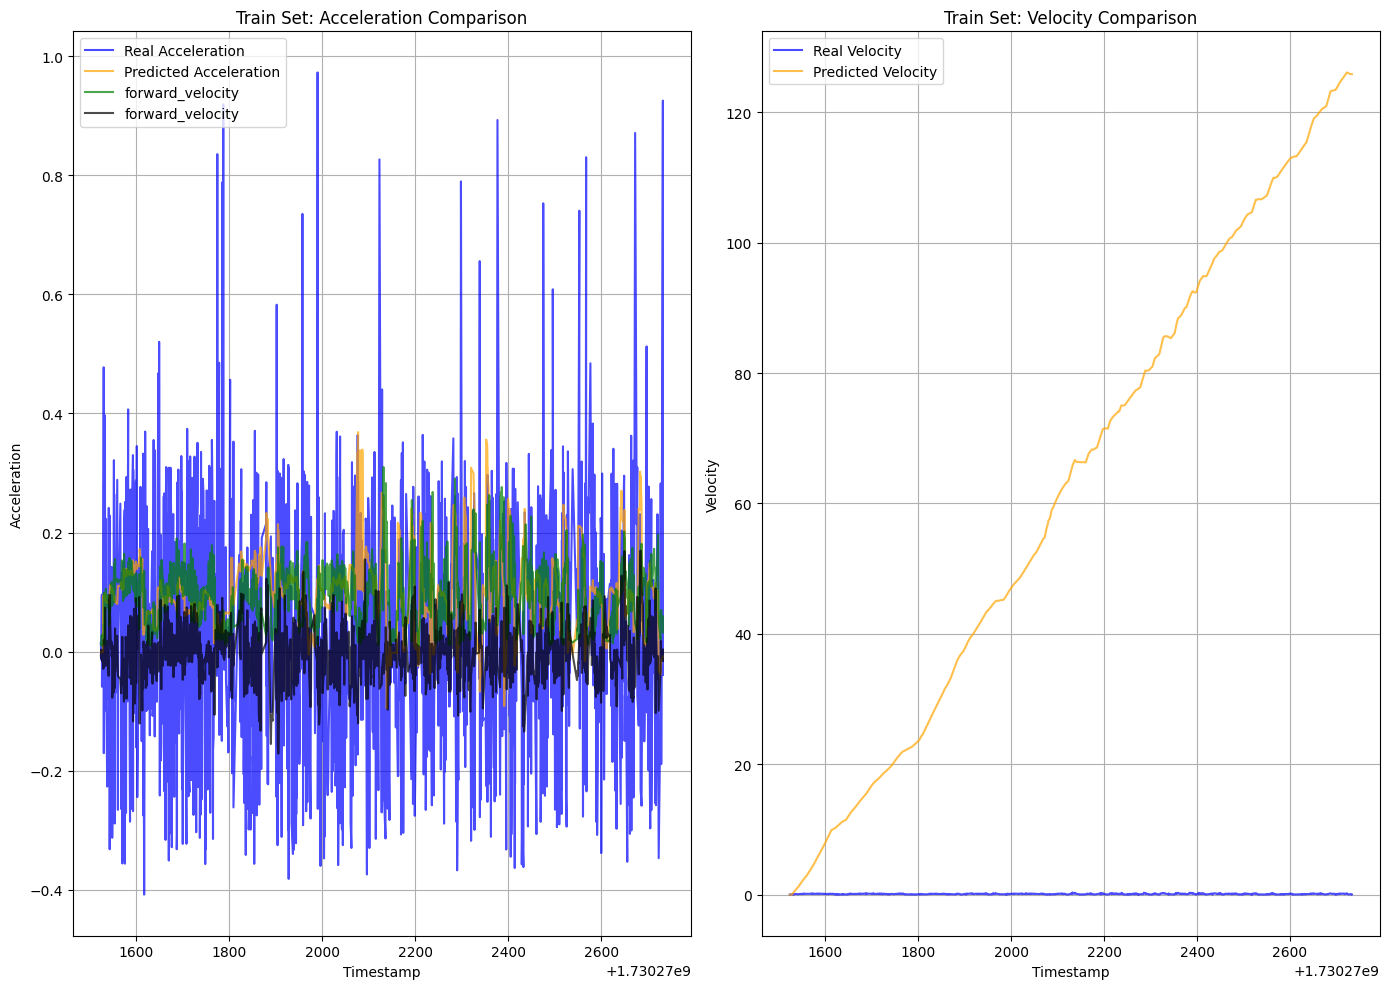

In [ ]:
def predict_acceleration_and_velocity(df, params):
    """
    根据拟合参数预测加速度和速度。
    """
    predicted_acceleration = []
    predicted_velocity = []
    velocity = 0  # 初始化速度为 0，假设初始速度为零或从数据中取值
    prevtime = df['timestamp'][0]
    for _, row in df.iterrows():
        u = row['forward_velocity']
        v = row['lateral_velocity']
        w = row['angular_velocity']
        f_l = row['state'][0]
        f_r = row['state'][1]

        # 预测加速度公式
        u_dot_pred = - 0.5*1000*params[0]*params[1]*u*np.sqrt(u**2+v**2)/17.446 + 0.5/17.446*1000*params[0]*params[2]*v*np.sqrt(u**2+v**2)*math.atan(v/u) \
                    + (params[3]*f_l**2 + params[4]*f_l + params[3]*f_r**2 + params[4]*f_r)/17.446

        predicted_acceleration.append(u_dot_pred)

        # 计算速度，使用简单的离散积分
        velocity += u_dot_pred * (row['timestamp'] - prevtime)
        predicted_velocity.append(velocity)
        prevtime = row['timestamp']
    return np.array(predicted_acceleration), np.array(predicted_velocity)

params = np.array([0.14190063 ,0.75 ,0.66, 0.65114722 ,1.69107612 ,1.  ,1.], dtype=np.float64)

# 获取预测的加速度和速度
train_predicted_acc, train_predicted_vel = predict_acceleration_and_velocity(df_filtered_filtered, params)


# 绘制对比图
plt.figure(figsize=(14, 10))
# 训练集加速度对比
plt.subplot(1, 2, 1)
plt.plot(df_filtered_filtered['timestamp'], df_filtered_filtered['forward_acceleration'], label='Real Acceleration', color='blue', alpha=0.7)
plt.plot(df_filtered_filtered['timestamp'], train_predicted_acc, label='Predicted Acceleration', color='orange', alpha=0.7)
plt.plot(df_filtered_filtered['timestamp'], df_filtered_filtered['forward_velocity'], label='forward_velocity', color='green', alpha=0.7)
plt.plot(df_filtered_filtered['timestamp'], df_filtered_filtered['lateral_velocity'], label='forward_velocity', color='black', alpha=0.7)
plt.title('Train Set: Acceleration Comparison')
plt.xlabel('Timestamp')
plt.ylabel('Acceleration')
plt.legend()
plt.grid()

# 训练集速度对比
plt.subplot(1, 2, 2)
plt.plot(df_filtered_filtered['timestamp'], df_filtered_filtered['forward_velocity'], label='Real Velocity', color='blue', alpha=0.7)
plt.plot(df_filtered_filtered['timestamp'], train_predicted_vel, label='Predicted Velocity', color='orange', alpha=0.7)
plt.title('Train Set: Velocity Comparison')
plt.xlabel('Timestamp')
plt.ylabel('Velocity')
plt.legend()
plt.grid()





plt.tight_layout()
plt.show()

In [160]:
def sgd_optimizer(df, learning_rate=0.01, epochs=100):
    train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

    # 初始化模型参数
    params = np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0])
    # 假设三个模型参数: [S_u, C_d, C_l, A_pl1, A_pl2, A_pr1, A_pr2]
    
    for epoch in range(epochs):
        total_train_loss = 0
        velocity = 0
        prevtime = train_df['timestamp'][0]
        for idx, row in train_df.iterrows():
            # 获取预测值
            u_dot = row['smoothed_forward_acceleration']
            # print(u_dot)
            u = row['smoothed_forward_velocity'] 
            v = row['lateral_velocity'] 
            w = row['angular_velocity']
            f_l = row['state'][0]
            f_r = row['state'][1]
            
            
            u_dot_pred =  - 0.5*1000*params[0]*params[1]*u*np.sqrt(u**2+v**2)/17.446 + 0.5/17.446*1000*params[0]*params[2]*v*np.sqrt(u**2+v**2)*math.atan(v/u) \
                    + (params[3]*f_l**2 + params[4]*f_l + params[3]*f_r**2 + params[4]*f_r)/17.446
            # print(u_dot)
            # 计算损失
            velocity += u_dot_pred * (row['timestamp'] - prevtime)
            prevtime = row['timestamp']
            loss = loss_function(np.array([u_dot_pred]), np.array([u_dot]) )#+ params[3]**2 + params[4]**2 + params[5]**2 + params[6]**2)
            total_train_loss += loss #+ velocity**2/100
            
            # 计算梯度
            grad_S_u = 20 * (u_dot_pred - u_dot) * (- 0.5*1000*params[1]*u*np.sqrt(u**2+v**2)/17.446 + 0.5/17.446*1000*params[2]*v*np.sqrt(u**2+v**2)*math.atan(v/u)) #+ 2*velocity/20
            grad_C_d = 20 * (u_dot_pred - u_dot) * (- 0.5*1000*params[0]*u*np.sqrt(u**2+v**2)/17.446) #+ 2*velocity/100
            grad_C_l = 20 * (u_dot_pred - u_dot) * (0.5/17.446*1000*params[0]*v*np.sqrt(u**2+v**2)*math.atan(v/u)) #+ 2*velocity/100
            grad_A_pl1 = 20 * (u_dot_pred - u_dot) * f_l**2 /17.446#+ 2*velocity #+ 2 * params[3]
            grad_A_pl2 = 20 * (u_dot_pred - u_dot) * f_l /17.446 #+ 2*velocity #+ 2 * params[4] 
            # grad_A_pr1 = 2 * (u_dot_pred - u_dot) * f_r**2 /17.446 #+ 2 * params[5]
            # grad_A_pr2 = 2 * (u_dot_pred - u_dot) * f_r /17.446 #+ 2 * params[6]
            
            # 更新参数
            params[0] -= learning_rate * grad_S_u
            # params[0] = max(params[0], 0)
            params[1] -= learning_rate * grad_C_d
            # params[1] = max(params[1], 0)
            params[2] -= learning_rate * grad_C_l
            # params[2] = max(params[2], 0)
            params[3] -= learning_rate * grad_A_pl1
            params[4] -= learning_rate * grad_A_pl2
            # params[5] -= learning_rate * grad_A_pr1
            # params[6] -= learning_rate * grad_A_pr2
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_train_loss/len(train_df)}")
        # print(f_l )
        # print(params[3]*f_l**2 + params[4]*f_l )
        # 在测试集上计算损失
        total_test_loss = 0
        for idx, row in test_df.iterrows():
            u_dot = row['forward_acceleration']
            u = row['forward_velocity']
            v = row['lateral_velocity']
            f_l = row['state'][0]
            f_r = row['state'][1]
            
            u_dot_pred = - 0.5 * 1000 * params[0] * params[1] * u * np.sqrt(u**2 + v**2) / 17.446 \
                        + 0.5 / 17.446 * 1000 * params[0] * params[2] * v * np.sqrt(u**2 + v**2) * math.atan(v / u) \
                        + (params[3] * f_l**2 + params[4] * f_l + params[3] * f_r**2 + params[4] * f_r) / 17.446
            
            loss = loss_function(np.array([u_dot_pred]), np.array([u_dot]))
            total_test_loss += loss

        # 打印训练损失和测试损失
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss/len(train_df)}, Test Loss: {total_test_loss/len(test_df)}")
        print(u_dot, u_dot_pred)
        print(params)
    return params

params = sgd_optimizer(df_filtered_filtered, learning_rate=0.0001, epochs=200)

Epoch 1/200, Loss: 0.5780379168698402
Epoch 1/200, Train Loss: 0.5780379168698402, Test Loss: 0.6768691195565276
-0.039078420834531176 -0.01694365018562123
[0.82126364 0.82469221 0.99718331 1.01028543 1.00726395 1.
 1.        ]
Epoch 2/200, Loss: 0.2918640776796933
Epoch 2/200, Train Loss: 0.2918640776796933, Test Loss: 0.5452948133545843
-0.039078420834531176 -0.012943361217810338
[0.72454623 0.7402225  0.98846405 1.01387448 1.00976158 1.
 1.        ]
Epoch 3/200, Loss: 0.20345431074414527
Epoch 3/200, Train Loss: 0.20345431074414527, Test Loss: 0.4954230589403294
-0.039078420834531176 -0.01078930963330971
[0.66074045 0.6922812  0.97844236 1.01428608 1.00998155 1.
 1.        ]
Epoch 4/200, Loss: 0.16564422367387863
Epoch 4/200, Train Loss: 0.16564422367387863, Test Loss: 0.47165376876647014
-0.039078420834531176 -0.009467822329023016
[0.61406204 0.66295607 0.96829024 1.01288782 1.00889171 1.
 1.        ]
Epoch 5/200, Loss: 0.14602945704098433
Epoch 5/200, Train Loss: 0.146029457040984

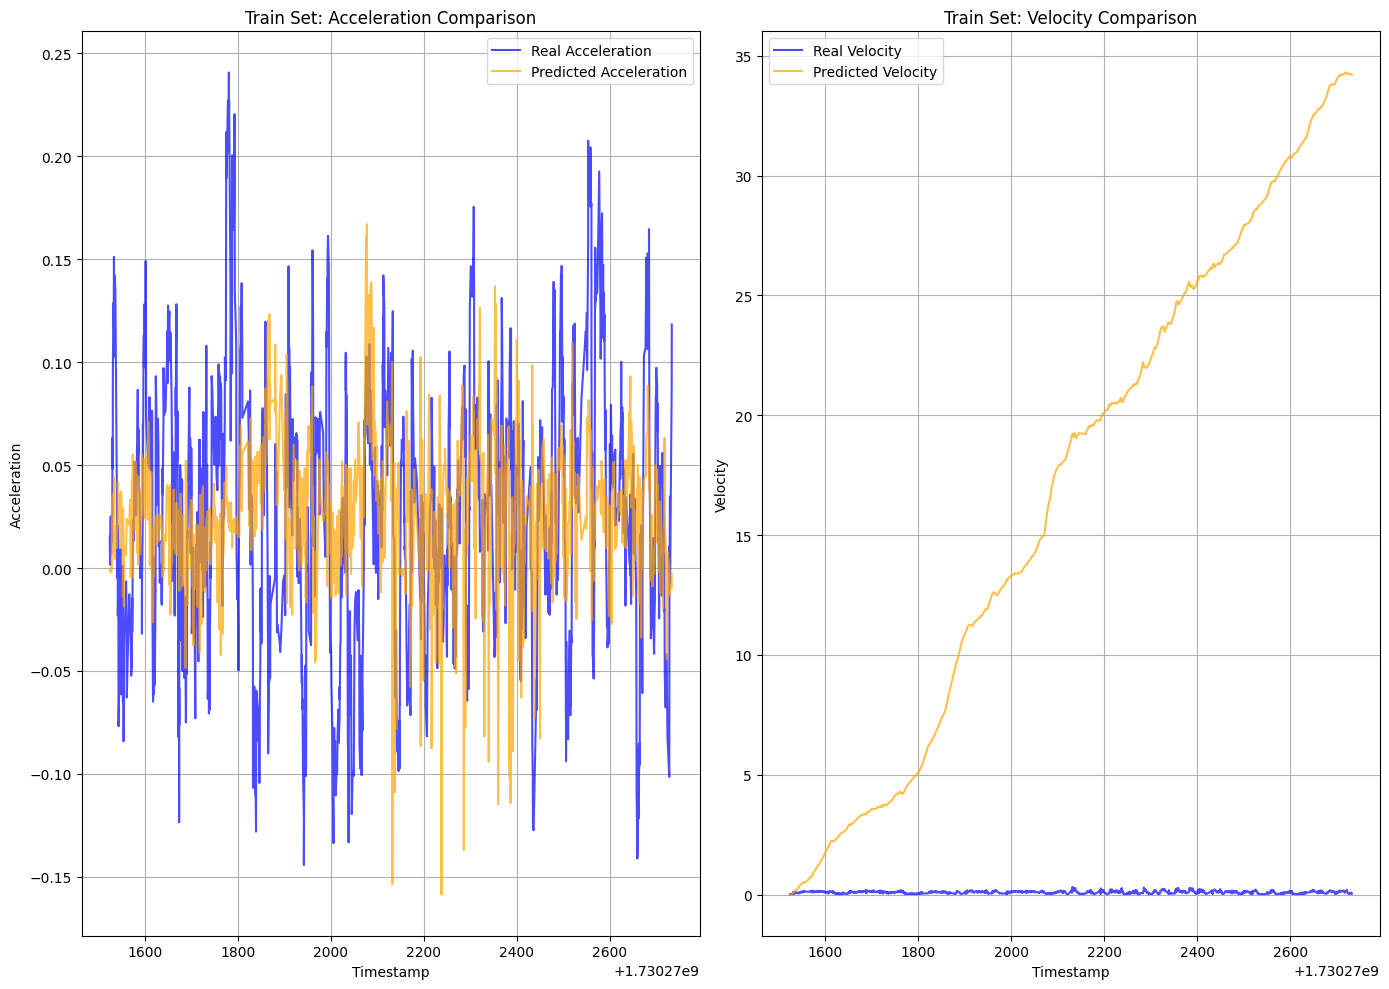

In [163]:
def predict_acceleration_and_velocity(df, params):
    """
    根据拟合参数预测加速度和速度。
    """
    predicted_acceleration = []
    predicted_velocity = []
    velocity = 0  # 初始化速度为 0，假设初始速度为零或从数据中取值
    prevtime = df['timestamp'][0]
    for _, row in df.iterrows():
        u = row['forward_velocity']
        v = row['lateral_velocity']
        w = row['angular_velocity']
        f_l = row['state'][0]
        f_r = row['state'][1]

        # 预测加速度公式
        u_dot_pred = - 0.5*1000*params[0]*params[1]*u*np.sqrt(u**2+v**2)/17.446 + 0.5/17.446*1000*params[0]*params[2]*v*np.sqrt(u**2+v**2)*math.atan(v/u) \
                    + (params[3]*f_l**2 + params[4]*f_l + params[3]*f_r**2 + params[4]*f_r)/17.446

        predicted_acceleration.append(u_dot_pred)

        # 计算速度，使用简单的离散积分
        velocity += u_dot_pred * (row['timestamp'] - prevtime)
        predicted_velocity.append(velocity)
        prevtime = row['timestamp']
    return np.array(predicted_acceleration), np.array(predicted_velocity)

# params = np.array([0.14190063 ,0.75 ,0.66, 0.65114722 ,1.69107612 ,1.  ,1.], dtype=np.float64)

# 获取预测的加速度和速度
train_predicted_acc, train_predicted_vel = predict_acceleration_and_velocity(df_filtered_filtered, params)


# 绘制对比图
plt.figure(figsize=(14, 10))
# 训练集加速度对比
plt.subplot(1, 2, 1)
plt.plot(df_filtered_filtered['timestamp'], df_filtered_filtered['smoothed_forward_acceleration'], label='Real Acceleration', color='blue', alpha=0.7)
plt.plot(df_filtered_filtered['timestamp'], train_predicted_acc, label='Predicted Acceleration', color='orange', alpha=0.7)
# plt.plot(df_filtered_filtered['timestamp'], df_filtered_filtered['forward_velocity'], label='forward_velocity', color='green', alpha=0.7)
# plt.plot(df_filtered_filtered['timestamp'], df_filtered_filtered['lateral_velocity'], label='forward_velocity', color='black', alpha=0.7)
plt.title('Train Set: Acceleration Comparison')
plt.xlabel('Timestamp')
plt.ylabel('Acceleration')
plt.legend()
plt.grid()

# 训练集速度对比
plt.subplot(1, 2, 2)
plt.plot(df_filtered_filtered['timestamp'], df_filtered_filtered['forward_velocity'], label='Real Velocity', color='blue', alpha=0.7)
plt.plot(df_filtered_filtered['timestamp'], train_predicted_vel, label='Predicted Velocity', color='orange', alpha=0.7)
plt.title('Train Set: Velocity Comparison')
plt.xlabel('Timestamp')
plt.ylabel('Velocity')
plt.legend()
plt.grid()





plt.tight_layout()
plt.show()